# Homework 5: Neural Networks (100 points)

In this homework, you will be implementing a fully connected neural network and a convolutional neural network using the PyTorch framework.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load the Dataset (MNIST)

We can use some PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [4]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)

# Plotting Data

You must sample 10 images (one from each class) from the dataset and plot them as a grid with 2 rows of 5 columns each (i.e. of shape `2 x 5`).

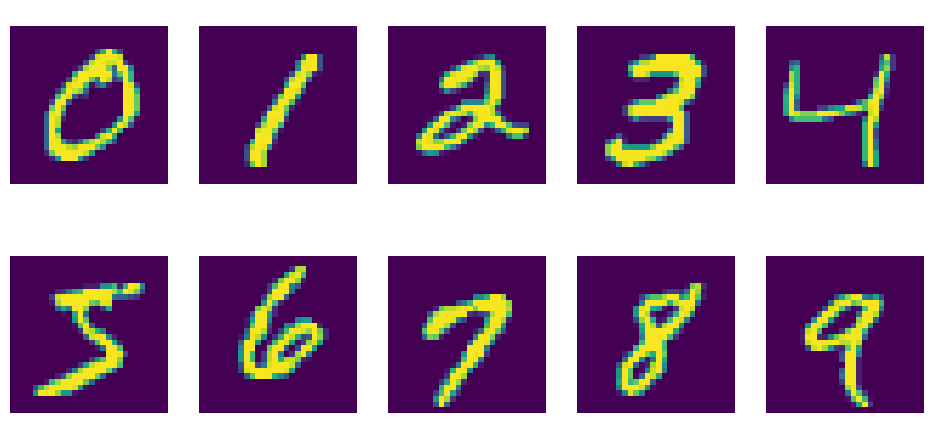

In [55]:
# TODO: Plot 10 images with one image from each class in the training set
seen_target = []
row, col = 2, 5
figure, axis_array = plt.subplots()
figure.tight_layout()
axis_array.set_axis_off()
for image, target in train_dataset:
        if len(seen_target) == 10:
            break
        for i in range(len(train_dataset)):
            if target not in seen_target:
                seen_target.append(target)
                figure.add_subplot(row, col, target + 1)
                plt.subplots_adjust(left = None, bottom = None, right = 1.5, top = None, wspace = None, hspace = None)
                plt.axis('off')
                plt.imshow(image[i].squeeze())

## Train a Fully Connected Neural Network on MNIST

### Define the network

Build a 3-layer fully connected neural network that takes an input of size 28 * 28 = `784`, outputs `10` classes and has a hidden layer of size `(8,8)`. Use ReLU non-linearity and apply a logSoftmax function on the final layer.

The model must have the following architecture:

```
linear_layer(input_size, n_hidden)
relu
linear_layer(n_hidden, n_hidden)
relu
linear_layer(n_hidden, output_size)
log_softmax
```

In [ ]:
class FCN(nn.Module):
    def __init__(self,  input_size, n_hidden, output_size):
        super(FCN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(input_size, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, output_size)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        out = F.log_softmax(x, dim = 1)
        return out

### Define train and test function

Complete the function for training and evaluating the model. You must use the cross entropy loss function for training the model.

Note:
- `permute` is a function passed as an argument to train and test functions.
- `permutation_order` is a 1D torch array of size 784 (=28*28). It contains the random order for permutating the pixels in the `28x28` images.

In [ ]:
def train(epoch, model, optimizer, permute_pixels=None, permutation_order=None):
    """
    Train the model for one epoch

    Args:
        epoch (int): current epoch
        model (nn.Module): model to train
        optimizer (torch.optim): optimizer to use
        permute_pixels (function): function to permute the pixels (default: None)
        permutation_order (1D torch array): order of the permutation (default: None)
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        if permute_pixels is not None:
            data = permute_pixels(data, permutation_order)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, permute_pixels=None, permutation_order=None):
    """
    Test the model

    Args:
        model (nn.Module): model to test
        permute (function): function to permute the pixels (default: None)
        permutation_order (1D torch array): order of the permutation (default: None)
    """
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        if permute_pixels is not None:
            data = permute_pixels(data, permutation_order)

        output = model(data)
        test_loss += F.nll_loss(output, target, reduction = 'sum') # sum up batch loss                                                               
        pred = output.argmax(dim = 1, keepdim = True)  # get the index of the max log-probability                                                                 
        correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    return accuracy

# Write a function for computing the total parameter count of the model

In [ ]:
# function to count number of parameters
def get_n_params(model):
    # return number of parameters in model
    return sum(p.numel() for p in model.parameters())

### Train a small fully-connected network

Optimizer : SGD with lr=0.01 and momentum=0.5

In [ ]:
n_hidden = 8 # number of hidden units

model_fcn = FCN(input_size, n_hidden, output_size)
model_fcn.to(device)
optimizer = torch.optim.SGD(model_fcn.parameters(), lr = 0.01, momentum = 0) # use SGD with learning rate 0.01 and momentum 0.5
print('Number of parameters: {}'.format(get_n_params(model_fcn)))

test_accuracy = []
for epoch in range(0, 1):
    train(epoch, model_fcn, optimizer)
    test_accuracy.append(test(model_fcn))

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.293240
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.187470
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.827733
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.610108
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.309860
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.865002
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.812873
Train Epoch: 0 [44800/60000 (75%)]	Loss: 1.034682
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.729931
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.556864

Test set: Average loss: 0.6019, Accuracy: 8193/10000 (82%)



## Train a Convolutional Neural Network (CNN) on MNIST

Define a convolutional neural network with the following architecture to classify the MNIST images.

```
Conv(
    conv2D(input_size, conv_feature, kernel_size=5)
    relu()
    maxpool2d(kernel_size=2)
    conv2d(conv_feature, conv_feature, kernel_size=5)
    relu()
    maxpool2d(kernel_size=2)
)

FC(
    linear_feature(conv_feature*4*4, fc_feature),
    relu(),
    linear_feature(fc_feature, output_size),
    log_softmax()
)
```

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_channels, conv_feature, fc_feature, output_size):
        super(CNN, self).__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(input_channels, conv_feature, kernel_size = 5)
        self.conv2 = nn.Conv2d(conv_feature, conv_feature, kernel_size = 5)
        self.max_pool = nn.MaxPool2d(kernel_size = 2)
        self.linear1 = nn.Linear(conv_feature * 4 * 4, fc_feature)
        self.linear2 = nn.Linear(fc_feature, output_size)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        out = F.log_softmax(x, dim = 1)
        return out

### Train a ConvNet with the same number of parameters

In [ ]:
# Training settings 
conv_features = 6 # number of feature maps
input_channels = 1 # number of input channels
fc_features = 50

model_cnn = CNN(input_channels, conv_features, fc_features, output_size) # create CNN model
model_cnn.to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(), lr = 0.01, momentum = 0.5) # use SGD with learning rate 0.01 and momentum 0.5
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

test_accuracy = []
for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer)
    test_accuracy.append(test(model_cnn))

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.331953
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.527762
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.382399
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.388709
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.288825
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.204233
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.259573
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.191819
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.134861
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.173418

Test set: Average loss: 0.1855, Accuracy: 9415/10000 (94%)



### Question: Why do you think the ConvNet performs better than the fully connected network even though both have the same number of parameters?


In fully connected neural network, every neuron in a given layer is connected to all neurons in the other layer.<br>
Convolutional neural network usually includes convolutional, pooling, and fully connected layer.<br>
The convolution layer in ConvNet is specialized to extract information that has locality such as adjacent pixels in an image,<br>
since the convolution layer performs convolution operation each time between a small portion of the input matrix with a kernel matrix<br>
and store the sum of products into each entry of the output matrix.<br>

### What happens if the assumptions are no longer true?

In [ ]:
# Given a permutation order, permute the pixels of the input image
def permute_pixels(data, permutation_order):
    """
    Permute the pixels of the input image
    
    Args:
        data (torch tensor): batch of input images of shape (B, 1, H, W) where B is the batch size, H is the height and W is the width.
        permutation_order (1D torch array): order of the permutation
    
    Returns:
        permuted_data (torch tensor): permuted batch of input images of shape (B, 1, H, W)
    """
    new_data = data.clone()
    if permutation_order is not None:
        for i in range(data.shape[0]):
            buf = data[i].view_as(permutation_order)
            buf2 = buf[permutation_order]
            new_data[i] = buf2.reshape(1, 28, 28)
    return new_data

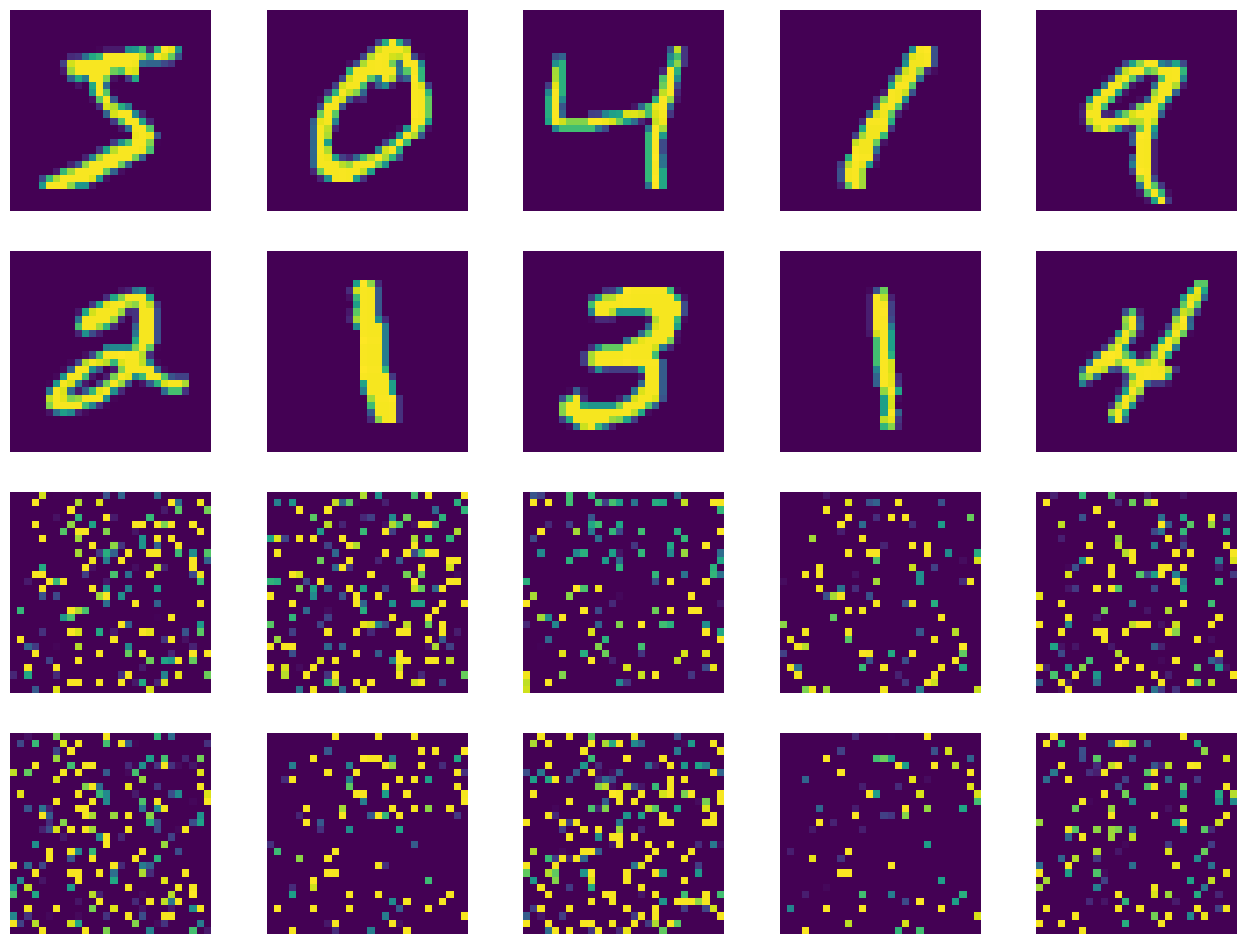

In [ ]:
permutation_order = torch.randperm(28*28)

plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    image = image[None, :]
    # permute pixels
    image_perm = permute_pixels(image.clone(), permutation_order)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

### ConvNet with permuted pixels

Train and evaluate a ConvNet with permuted pixels.

In [ ]:
# Training settings 
conv_features = 6 # number of feature maps
fc_features = 50

model_cnn = CNN(input_channels, conv_features, fc_features, output_size) # create CNN model
model_cnn.to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(), lr = 0.01, momentum = 0.5) # use SGD with learning rate 0.01 and momentum 0.5
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer, permute_pixels, permutation_order)
    test(model_cnn, permute_pixels, permutation_order)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.321749
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.264074
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.151710
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.788048
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.197768
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.006676
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.906457
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.666290
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.458520
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.494813

Test set: Average loss: 0.5797, Accuracy: 8133/10000 (81%)



### Fully-Connected with Permuted Pixels

Train and evaluate a fully connected network with permuted pixels.

In [ ]:
n_hidden = 8    # number of hidden units

model_fnn = FCN(input_size, n_hidden, output_size) # create FCN model
model_fnn.to(device)
optimizer = torch.optim.SGD(model_fnn.parameters(), lr = 0.01, momentum = 0.5) # use SGD with learning rate 0.01 and momentum 0.5
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, optimizer, permute_pixels)
    test(model_fnn, permute_pixels)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.347832
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.930412
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.388640
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.932932
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.670085
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.538468
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.749481
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.540626
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.628124
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.757884

Test set: Average loss: 0.5755, Accuracy: 8183/10000 (82%)



### Question: We observe that the ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same. Provide an explanation for this.

When pixels are permuted, the original locality of pixel information is distorted and lost,<br>
for example, a certain pixel value might be concentrated inside a small portion of original image with the size of the sliding matrix,
but after permutation of the pixels, the pixel that was dominant in that portion of the image scattered into other locations in
the image (outside of the boundary defined by the sliding matrix)<br> 
then the advantage of using the convolution layer drops.<br>
Since the convolution layer in ConvNet is specialized to extract information that has locality such as adjacent pixels in an image,<br>
and then features are constructed from that neighborhood.<br>